### Import Useful packages

In [1]:
import math
import lal
import lalsimulation as lalsim
import numpy as np
import matplotlib.pyplot as plt 
import random as rnd
import nlopt
import copy
import typing as typ
import dataclasses as datacl

from pycbc.filter import match as simple_match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform.utils import coalign_waveforms

/tmp/ipykernel_6350/3861781112.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


### Chirp_mass function

In [2]:
def chirp_mass_function(masses:list)->float:

    return ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))

### Define the parameters to optimize as a class

In [3]:
class params:
    def __init__(self, masses:tuple, spin1:tuple = (0,0,0) ,spin2:tuple= (0,0,0), r: float = 1e6 * lal.PC_SI,
                  incl:float = 0, phiRef:float = 0, longAscNodes:float=0, ecc:float = 0, meanPerAno:float = 0):
        # Atributo de instancia (Se vincula a la instancia)
        self.m1: float = masses[0]
        self.m2: float = masses[1]
        self.s1x:float = spin1[0]
        self.s1y:float = spin1[1]
        self.s1z:float = spin1[2]
        self.s2x:float = spin2[0]
        self.s2y:float = spin2[1]
        self.s2z:float = spin2[2]
        self.distance:float = r
        self.inclination:float = incl
        self.phiRef:float = phiRef
        self.longAscNodes:float = longAscNodes
        self.eccentricity:float = ecc
        self.meanPerAno : float = meanPerAno


    def chirp_mass(self) -> float:
        return chirp_mass_function([self.m1, self.m2])
    
    def cambiar_valor_paso(self, n_param: int, h:float, a:float) -> None:
        param_keys = list(self.__dict__.keys())
        param_values = list(self.__dict__.values())
        atributo = param_keys[n_param]
        
        setattr(self, atributo, param_values[n_param]+a*h)

    def __str__(self) -> str:
        return f"mass1: {self.m1} | mass2: {self.m2} | spin1: {self.s1x, self.s1y, self.s1z}| spin2: {self.s2x, self.s2y, self.s2z}, | distance: {self.distance}, |inclination: {self.inclination}, |phiRef: {self.phiRef}, |longAscNodes: {self.longAscNodes}, |eccentricity: {self.eccentricity}| meanPerAno: {self.meanPerAno}"

### Define the simulation function for arbitrary binary systems

We are considering the following parameters: masses of the BH, spins (all components), distance, inclination and eccentricity (I'm not sure that eccentricity works) using the domminant modes

In [4]:
def simulationTD_IMRPhenomTPHM(parameters: params, delta_T:float, f_min:float, f_ref:float)->tuple:

    Approximant = "IMRPhenomTPHM"

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(waveform_params, mode_array)


    with lal.no_swig_redirect_standard_output_error():
    # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(**parameters.__dict__,
        deltaT=delta_T, f_min=f_min, f_ref=f_ref, params=waveform_params, approximant=lalsim.GetApproximantFromString(Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data 
    time = np.arange(len(h_plus)) * delta_T

    return h_plus, h_cross, time # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example

### Define the match function

In [5]:
def perform_match(hnr, hap, f_lower, f_high, optimized = False, return_phase = False)->tuple:
    FD = isinstance(hnr, FrequencySeries)
    if not FD: 
        hnr, hap = hnr.real(), hap.real()
    
    # Match signal sizes
    length = min(len(hnr), len(hap))
    hnr.resize(length); hap.resize(length)

    # Compute PSD
    if FD: 
        delta_f = hnr.delta_f
    else:
        delta_f = 1/hnr.duration
    
    psd = aLIGOZeroDetHighPower(length, delta_f, f_lower)
    
    # Compute Match
    match_kwargs = dict(vec1 = hnr, vec2 = hap, psd = psd, low_frequency_cutoff = f_lower, high_frequency_cutoff = f_high, return_phase = return_phase)
    return optimized_match(**match_kwargs) if optimized else simple_match(**match_kwargs, subsample_interpolation = True)

### Define and Simulate the target gravitational Wave

In [6]:
mass1_target = 50 * lal.MSUN_SI
mass2_target = 10 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0,0.0,0.8)
spin2_target = (0,0,0.9)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)



### Define the function to optimize

We will optimize the match, but the nlopt package minimizes the function given. We want to maximize it, so our function have a minus sign at the end to take this into account. Moreover, we want to optimize a function which only receives the free parameters so the rest will be received as global constants.

We define two different functions. One is using a derivative-free algorithm and the other ones takes the derivatives into account.

In [7]:
def opt_match(prms:list, grad): # masses = [m1, m2]

    parameters = params((prms[0],prms[1]), (prms[2] ,prms[3] ,prms[4]), (prms[5] ,prms[6] ,prms[7]))


    if (prms[2]**2+prms[3]**2+prms[4]**2-1)>0 or (prms[5]**2+prms[6]**2+prms[7]**2-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data

    hp = TimeSeries(hp, delta_t = delta_T) 

    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

In [8]:
def sym_derivative_match(parameters:params, n_param:int, h):

    parameters_plus=copy.copy(parameters)
    parameters_minus=copy.copy(parameters)

    parameters_plus.cambiar_valor_paso(n_param, h, 1)
    parameters_minus.cambiar_valor_paso(n_param, h, -1)


    hp_plus, hc, time = simulationTD_IMRPhenomTPHM(parameters_plus, delta_T, f_min, f_ref) 
    hp_plus = TimeSeries(hp_plus, delta_t = delta_T) 
    hp_minus, hc, time = simulationTD_IMRPhenomTPHM(parameters_minus, delta_T, f_min, f_ref) 
    hp_minus = TimeSeries(hp_minus, delta_t = delta_T) 


    match_plus,_ = perform_match(hp_target, hp_plus, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_minus,_ = perform_match(hp_target, hp_minus, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return (match_plus-match_minus)/2*h


def Richardson_derivative_match(parameters, n_param:int, h):

    parameters_1=copy.copy(parameters)
    parameters_2=copy.copy(parameters)
    parameters_3=copy.copy(parameters)
    parameters_4=copy.copy(parameters)

    parameters_1.cambiar_valor_paso(n_param, h, 1)
    parameters_2.cambiar_valor_paso(n_param, h, -1)
    parameters_3.cambiar_valor_paso(n_param, h, 1/2)
    parameters_4.cambiar_valor_paso(n_param, h, -1/2)


    hp_1, hc, time = simulationTD_IMRPhenomTPHM(parameters_1, delta_T, f_min, f_ref) 
    hp_1 = TimeSeries(hp_1, delta_t = delta_T) 
    hp_2, hc, time = simulationTD_IMRPhenomTPHM(parameters_2, delta_T, f_min, f_ref) 
    hp_2 = TimeSeries(hp_2, delta_t = delta_T) 
    hp_3, hc, time = simulationTD_IMRPhenomTPHM(parameters_3, delta_T, f_min, f_ref) 
    hp_3 = TimeSeries(hp_3, delta_t = delta_T) 
    hp_4, hc, time = simulationTD_IMRPhenomTPHM(parameters_4, delta_T, f_min, f_ref) 
    hp_4 = TimeSeries(hp_4, delta_t = delta_T) 
    

    match_1,_ = perform_match(hp_target, hp_1, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_2,_ = perform_match(hp_target, hp_2, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_3,_ = perform_match(hp_target, hp_3, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_4,_ = perform_match(hp_target, hp_4, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return (match_1-match_2-8*(match_3-match_4))/(-6*h)

In [9]:
def opt_match_grad(prms:list, grad): # masses = [m1, m2]

    parameters = params((prms[0],prms[1]), (prms[2],prms[3],prms[4]), (prms[5],prms[6],prms[7]))

    if (prms[2]**2+prms[3]**2+prms[4]**2-1)>0 or (prms[5]**2+prms[6]**2+prms[7]**2-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin

    h_mass = 0.05*lal.MSUN_SI #Paso para derivar en funcion de las masas
    h_spin = 0.05 #Paso para derivar en funcion del spin
    h_distance = 5*1e4* lal.PC_SI #Paso para derivar en funcion de la distancia
    h_resto = 0.0005 # Resto de pasos (es un valor bajo porque no quiero que cambien en este caso)

    h = [h_mass, h_mass, h_spin, h_spin, h_spin, h_spin, h_spin, h_spin]# h_distance, h_resto]

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 

    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    if grad.size > 0:
        for i in range(len(prms)):
            grad[i] = - Richardson_derivative_match(parameters, i, h[i]) # EL negativo es porque nlopt minimiza funciones no las maximiza


    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

# Optimizacion para spines arbitrarios

### Spin-Constraint

Para tener agujeros negros y no singularidades desnudas debemos forzar la siguiente constraint sobre los espines:

$$ 
|S_i|<1.
$$

Puesto que elevar al cuadrado un número menor que uno siempre nos da un número menos que uno y elevar al cuadrado un número mayor que uno siempre da un número mayor que uno podemos imponer en su lugar la siguiente constraint:

$$
s_{ix}^2+s_{iy}^2+s_{iz}^2-1<0.
$$

In [10]:
def spin_constraint(prms, grad, n_BH): 

    # n_BH es 0 ó 1. 0 hace referencia al primer BH y 1 hace referencia al segundo. De esta forma podemos utilizar el constraint para cualquiera de los dos BH
    if grad.size > 0:  
        grad[:] = 0    # Rellena el gradiente con ceros 
    return prms[2+3*n_BH]**2+prms[3+3*n_BH]**2+prms[4+3*n_BH]**2-1 # Escribo 0.99 en vez de 1 para evitar errores

def spin_constraint_grad(prms, grad, n_BH): 

    # n_BH es 0 ó 1. 0 hace referencia al primer BH y 1 hace referencia al segundo. De esta forma podemos utilizar el constraint para cualquiera de los dos BH

    if grad.size>0:
        for i in range(len(prms)):
        
            if i == 2+3*n_BH or 3+3*n_BH or 4+3*n_BH:
                grad[i] = 2*prms[i]
            else:
             grad[i] = 0

    return prms[2+3*n_BH]**2+prms[3+3*n_BH]**2+prms[4+3*n_BH]**2-1


### Vamos a empezar con el metodo sin derivadas


In [11]:
opt = nlopt.opt(nlopt.LN_NELDERMEAD, 8) # De los que he probado AUGLAG es el que mejor va
opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI, 0, 0, 0, 0, 0, 0]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors

opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)

opt.set_min_objective(opt_match)
params_initial=[12* lal.MSUN_SI, 57* lal.MSUN_SI, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

#opt.add_inequality_constraint(lambda params_final,grad: spin_constraint(params_final ,grad, 0), 1e-8)
#opt.add_inequality_constraint(lambda params_final,grad: spin_constraint(params_final ,grad, 1), 1e-8)

opt.set_xtol_rel(1e-4)
# opt.set_stopval(-1+1e-4)

params_final = opt.optimize(params_initial)
max_match = - opt.last_optimum_value()

""" chirp_mass_target = ((mass1_target*mass2_target)**(3/5))/((mass1_target+mass2_target)**(1/5))
chirp_mass = ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))
print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}") """

print(f"Optimum at masses {params_final[0]/lal.MSUN_SI} y {params_final[1]/lal.MSUN_SI} masas solares y parámetros de spin {params_final[2],params_final[3],params_final[4]} y {params_final[5],params_final[6],params_final[7]}")
print(f"El target se situaba en {mass1_target/lal.MSUN_SI} y {mass2_target/lal.MSUN_SI} masas solares y parámetros de spin {spin1_target} y {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp_mass: {chirp_mass_function([params_final[0],params_final[1]])}, chirp_mass_target: {chirp_mass_function([mass1_target,mass2_target])}")
print(f"result code = {opt.last_optimize_result()}")

opt2 = nlopt.opt(nlopt.LN_NELDERMEAD, 8)
opt2.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI, 0, 0, 0, 0, 0, 0]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt2.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt2.set_min_objective(opt_match)
opt2.set_xtol_rel(1e-4)
params_final = opt2.optimize(params_final)
max_match = - opt2.last_optimum_value()

print(f"Optimum at masses {params_final[0]/lal.MSUN_SI} y {params_final[1]/lal.MSUN_SI} masas solares y parámetros de spin {params_final[2],params_final[3],params_final[4]} y {params_final[5],params_final[6],params_final[7]}")
print(f"El target se situaba en {mass1_target/lal.MSUN_SI} y {mass2_target/lal.MSUN_SI} masas solares y parámetros de spin {spin1_target} y {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp_mass: {chirp_mass_function([params_final[0],params_final[1]])}, chirp_mass_target: {chirp_mass_function([mass1_target,mass2_target])}")
print(f"result code = {opt2.last_optimize_result()}")

KeyboardInterrupt: 

The nearest match is 0.6713783609131049


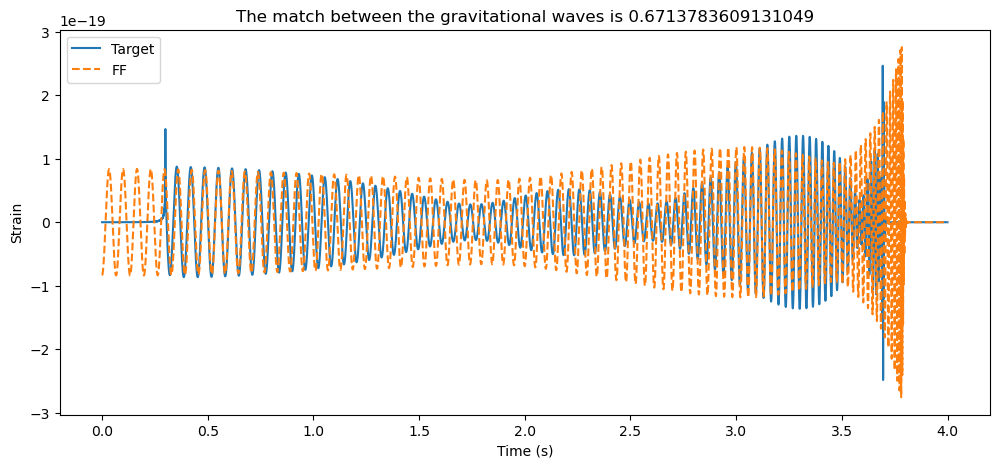

In [219]:
# Waveforms Coaligned
parameters_final = params((params_final[0],params_final[1]), (params_final[2],params_final[3],params_final[4]), (params_final[5],params_final[6],params_final[7])) 
hp_FF, hc_FF, time = simulationTD_IMRPhenomTPHM(parameters_final, delta_T, f_min, f_ref)
hp_FF=TimeSeries(hp_FF, delta_t=delta_T)
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_FF)

print(f"The nearest match is {max_match}")

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'FF', linestyle='dashed')
plt.title(f'The match between the gravitational waves is {max_match}')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

### Ahora vamos a utilizar el métodos con derivadas, comparamos usar la derivada simétrica con Richardson

In [203]:
opt = nlopt.opt(nlopt.LD_AUGLAG, 8) # De los que he probado AUGLAG es el que mejor va

# Definir un optimizador auxiliar (por ejemplo, LD_MMA)
local_opt = nlopt.opt(nlopt.LN_AUGLAG, 8)
opt.set_local_optimizer(local_opt)

opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI, 0, 0, 0, 0, 0, 0]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)


opt.set_min_objective(opt_match_grad)
opt.set_xtol_rel(1e-4)
# opt.set_stopval(-1+1e-1)


params_initial=[12* lal.MSUN_SI, 57* lal.MSUN_SI, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
""" opt.add_inequality_constraint(lambda params_final,grad: spin_constraint_grad(params_final,grad,0), 1e-8)
opt.add_inequality_constraint(lambda params_final,grad: spin_constraint_grad(params_final,grad,1), 1e-8) """
params_final = opt.optimize(params_initial)
max_match = - opt.last_optimum_value()

""" chirp_mass_target = ((mass1_target*mass2_target)**(3/5))/((mass1_target+mass2_target)**(1/5))
chirp_mass = ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))
print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}") """

print(f"Optimum at masses {params_final[0]/lal.MSUN_SI} y {params_final[1]/lal.MSUN_SI} masas solares y parámetros de spin {params_final[2],params_final[3],params_final[4]} y {params_final[5],params_final[6],params_final[7]}")
print(f"El target se situaba en {mass1_target/lal.MSUN_SI} y {mass2_target/lal.MSUN_SI} masas solares y parámetros de spin {spin1_target} y {spin2_target}")
print(f"maximum value = {max_match}")
print(f"result code = {opt.last_optimize_result()}")

mass1: 2.386091844837661e+31 | mass2: 1.133393626297889e+32 | spin1: (np.float64(0.5), np.float64(0.5), np.float64(0.5))| spin2: (np.float64(0.5), np.float64(0.5), np.float64(0.5)), | distance: 3.085677581491367e+22, |inclination: 0, |phiRef: 0, |longAscNodes: 0, |eccentricity: 0| meanPerAno: 0
0.32722729933436767
mass1: 4.0265299881635525e+31 | mass2: 1.133393626297889e+32 | spin1: (np.float64(0.5), np.float64(0.5), np.float64(0.5))| spin2: (np.float64(0.5), np.float64(0.5), np.float64(0.5)), | distance: 3.085677581491367e+22, |inclination: 0, |phiRef: 0, |longAscNodes: 0, |eccentricity: 0| meanPerAno: 0
0.0988278324440729
mass1: 2.386091844837661e+31 | mass2: 2.1176565122934244e+32 | spin1: (np.float64(0.5), np.float64(0.5), np.float64(0.5))| spin2: (np.float64(0.5), np.float64(0.5), np.float64(0.5)), | distance: 3.085677581491367e+22, |inclination: 0, |phiRef: 0, |longAscNodes: 0, |eccentricity: 0| meanPerAno: 0
0.19232067003219167
mass1: 1.9423184670474672e+31 | mass2: 9.7612188292

KeyboardInterrupt: 

### Prueba con un algoritmo global y luego perfilar con AUGLAG, NELDERMEAD o el que sea

In [225]:
opt = nlopt.opt(nlopt.GN_MLSL, 8) # De los que he probado AUGLAG es el que mejor va
opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI, 0, 0, 0, 0, 0, 0]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors

opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)

opt.set_min_objective(opt_match)
params_initial=[12* lal.MSUN_SI, 57* lal.MSUN_SI, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

#opt.add_inequality_constraint(lambda params_final,grad: spin_constraint(params_final ,grad, 0), 1e-8)
#opt.add_inequality_constraint(lambda params_final,grad: spin_constraint(params_final ,grad, 1), 1e-8)

opt.set_xtol_rel(1e-2)
# opt.set_stopval(-1+1e-4)

params_final = opt.optimize(params_initial)
max_match = - opt.last_optimum_value()

""" chirp_mass_target = ((mass1_target*mass2_target)**(3/5))/((mass1_target+mass2_target)**(1/5))
chirp_mass = ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))
print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}") """

print(f"Optimum at masses {params_final[0]/lal.MSUN_SI} y {params_final[1]/lal.MSUN_SI} masas solares y parámetros de spin {params_final[2],params_final[3],params_final[4]} y {params_final[5],params_final[6],params_final[7]}")
print(f"El target se situaba en {mass1_target/lal.MSUN_SI} y {mass2_target/lal.MSUN_SI} masas solares y parámetros de spin {spin1_target} y {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp_mass: {chirp_mass_function([params_final[0],params_final[1]])}, chirp_mass_target: {chirp_mass_function([mass1_target,mass2_target])}")
print(f"result code = {opt.last_optimize_result()}")

opt2 = nlopt.opt(nlopt.LN_NELDERMEAD, 8)
opt2.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI, 0, 0, 0, 0, 0, 0]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt2.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt2.set_min_objective(opt_match)
opt2.set_xtol_rel(1e-4)
params_final = opt2.optimize(params_final)
max_match = - opt2.last_optimum_value()

print(f"Optimum at masses {params_final[0]/lal.MSUN_SI} y {params_final[1]/lal.MSUN_SI} masas solares y parámetros de spin {params_final[2],params_final[3],params_final[4]} y {params_final[5],params_final[6],params_final[7]}")
print(f"El target se situaba en {mass1_target/lal.MSUN_SI} y {mass2_target/lal.MSUN_SI} masas solares y parámetros de spin {spin1_target} y {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp_mass: {chirp_mass_function([params_final[0],params_final[1]])}, chirp_mass_target: {chirp_mass_function([mass1_target,mass2_target])}")
print(f"result code = {opt2.last_optimize_result()}")

KeyboardInterrupt: 